# Prerequisites

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import box_ops
from data import WasteSet, get_waste, standardize_inv
from PIL import Image
from selectivesearch import SelectiveSearch
from tqdm.notebook import tqdm
from utils import show_annotation, show_cmap, filter_and_label_proposals

data_path = '/dtu/datasets1/02514/data_wastedetection'

# Dataloader

In [2]:
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = get_waste(
    8, num_workers=8, data_augmentation=True, supercategories=True)

len(train_dataset), len(val_dataset), len(test_dataset)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


(1050, 225, 225)

In [3]:
ims, targets = next(iter(train_loader))
len(ims), len(targets)

(8, 8)

In [4]:
targets[0]

{'bboxes': tensor([[0.1517, 0.3476, 0.0297, 0.0131]]),
 'category_ids': tensor([8]),
 'size': (512, 682)}

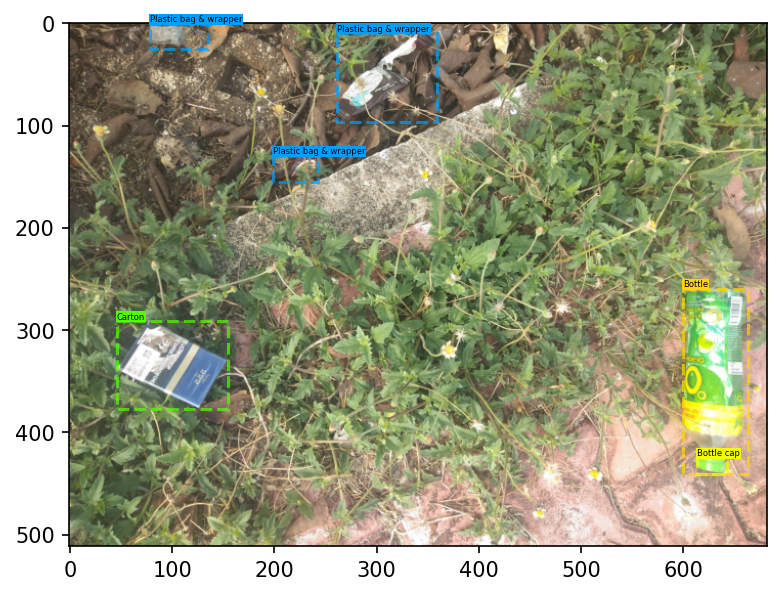

In [5]:
idx = 7

im, _ = standardize_inv(ims[idx], None)
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=150)
ax.imshow(np.moveaxis(im.numpy(), 0, 2))
show_annotation(targets[idx], ax, names=train_dataset.cat_names)

In [6]:
ims[2].shape

torch.Size([3, 512, 682])

# Object proposals

In [7]:
# Selective search module
ss = SelectiveSearch(mode='f', nkeep=400)

ims, targets = next(iter(train_loader))

In [8]:
# Get region proposals and preprocess them
proposals_batch = [ss((np.moveaxis(im.numpy(), 0, 2) * 255).astype(np.uint8)) for im in ims]

In [9]:
len(proposals_batch)

8

In [10]:
# max_proposals = 3
# proposals_batch_labels = []
# for i, target in enumerate(targets):
#     proposals = proposals_batch[i]
#     h, w = target['size']
#     if target['bboxes'].shape[0] == 0:
#         proposals = proposals[np.random.choice(proposals.shape[0], size=max_proposals, replace=False)]
#         proposal_labels = max_proposals * [0]
#     else:
#         proposal_labels = np.zeros(proposals.shape[0])
#         proposals_unit = proposals / np.array([w, h, w, h])
#         ious = np.stack([box_ops.compute_ious(box.numpy(), proposals_unit) for box in target['bboxes']])
#         mask = (ious > .5).any(axis=0)
#         ious_filter = ious[:, mask]
#         proposal_labels[mask] = target['category_ids'].numpy()[ious_filter.argmax(0)]
#     # Include all positives and 3/4 parts background.
#     include = np.where(proposal_labels != 0)[0]
#     include = np.where(proposal_labels == 0)[0][:max(3 * include.size, max_proposals)]
#     proposals = proposals[include]
#     proposal_labels = proposal_labels[include]
    
#     proposals_batch[i] = proposals
#     proposals_batch_labels.append(proposal_labels)

In [27]:
proposals_batch, proposals_batch_labels = filter_and_label_proposals(proposals_batch, targets)

In [31]:
# Merge with gt boxes

boxes_batch = np.vstack([np.vstack((proposal_boxes, target['bboxes'].numpy())) 
               for proposal_boxes, target in zip(proposals_batch, targets)])
y_true = np.concatenate([np.concatenate((proposal_labels, target['category_ids'].numpy())) 
                for proposal_labels, target in zip(proposals_batch_labels, targets)])

In [32]:
y_true = torch.tensor(y_true)
X = []
resize = transforms.Resize((256, 256))
for im, (x, y in zip(ims, proposals_batch):
    X.append(resize.forward(im[:, y:y+h, x:x+w]))


NameError: name 'h' is not defined

In [18]:
labels

tensor([ 0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,
         5.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,
         0.,  9.,  9.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       dtype=torch.float64)

In [14]:
# proposals_batch, proposals_batch_labels